In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [15]:
from src.data.make_dataset import INDEX_SHEET_NAME
from src.data.make_dataset import load_data

INDEX_SHEET_NAME

['HangSeng Index Data',
 'S&P500 Index Data',
 'CSI300 Index Data',
 'DJIA index Data',
 'Nikkei 225 index Data',
 'Nifty 50 index Data']

In [19]:
raw = load_data(sheet_name=INDEX_SHEET_NAME[0])

In [61]:
from src.features.build_features import generate_features

generate_features(raw, sheet_name=INDEX_SHEET_NAME[0])

>>>> Feature generation complete! <<<<


In [67]:
# wavelet transform

import os 
data_dir = f'../data/interim/{INDEX_SHEET_NAME[0]}'
train_lst = os.listdir(data_dir)
name = train_lst[0]

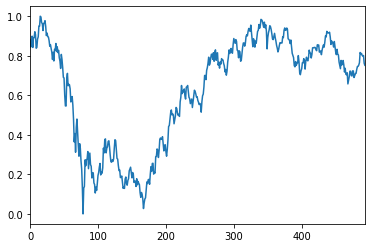

In [104]:
import numpy as np

def min_max_scale(X, X_train):
    return (X-X_train.min(axis=0))/(X_train.max(axis=0)-X_train.min(axis=0))


X_train = np.load(data_dir+f'/{name}/X_train.npy').astype(np.float32)
X_train = min_max_scale(X_train, X_train)
pd.Series(X_train[:,0]).plot()
X_train.shape

Y_train = np.load(data_dir+f'/{name}/Y_train.npy').astype(np.float32)
Y_train = min_max_scale(Y_train, Y_train)

In [92]:
from src.models.wavelet import wavelet_transform

X_train = wavelet_transform(X_train)
X_train = wavelet_transform(X_train)

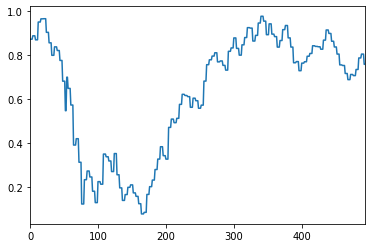

In [93]:
import pandas as pd
pd.Series(X_train[:,0]).plot()

In [97]:
from src.models.stacked_auto_encoder import StackedAutoEncoder


sae = StackedAutoEncoder(layers=4, 
                         original_dim=X_train.shape[1],
                         intermidiate_dim=10)

sae.train_stacked_ae(inputs=X_train,
                     learning_rate=0.01,
                     n_epochs=20)

Start to train Layer 1.
1/20 Average loss per epoch: 111.06380208333333
6/20 Average loss per epoch: 62.426876068115234
11/20 Average loss per epoch: 56.5505739847819
16/20 Average loss per epoch: 43.764059702555336
Start to train Layer 2.
1/20 Average loss per epoch: 42.34632110595703
6/20 Average loss per epoch: 19.160158157348633
11/20 Average loss per epoch: 15.229889869689941
16/20 Average loss per epoch: 13.106122652689615
>>>>Layer 2 trained!<<<<
Start to train Layer 3.
1/20 Average loss per epoch: 45.7322146097819
6/20 Average loss per epoch: 16.069238980611164
11/20 Average loss per epoch: 8.599502722422281
16/20 Average loss per epoch: 7.695893128712972
>>>>Layer 3 trained!<<<<
Start to train Layer 4.
1/20 Average loss per epoch: 32.258199055989586
6/20 Average loss per epoch: 3.312276919682821
11/20 Average loss per epoch: 1.9134785731633503
16/20 Average loss per epoch: 1.6873102188110352
>>>>Layer 4 trained!<<<<


In [99]:
X_train_e = sae.encode(X_train)
X_train_e.shape

(494, 10)

In [107]:
data_mean = X_train_e.mean(axis=0)
data_std = X_train_e.std(axis=0)
dataset = (X_train_e-data_mean)/data_std
target = Y_train

In [114]:
from src.models.LSTM import build_lstm_model, generate_slice_data
past_history = 4

target = Y_train

x_train, y_train = generate_slice_data(dataset, target, past_history)
# x_val, y_val = multivariate_data(dataset, target,past_history,)

In [115]:
import tensorflow as tf
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 10

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_data = val_data.batch(BATCH_SIZE).repeat()


In [121]:
lstm = build_lstm_model(x_train.shape[-2:], layers=5, units=[64, 64, 64, 64, 64])
lstm.fit(train_data, epochs=EPOCHS,
        steps_per_epoch=EVALUATION_INTERVAL)
        # validation_data=val_data,
        #validation_steps=50)

Train for 200 steps
Epoch 1/10
200/200 [==============================] - 23s 117ms/step - loss: 0.0706 - accuracy: 0.0036
Epoch 2/10
200/200 [==============================] - 11s 53ms/step - loss: 0.0030 - accuracy: 0.0041
Epoch 3/10
200/200 [==============================] - 10s 52ms/step - loss: 0.0026 - accuracy: 0.0041
Epoch 4/10
200/200 [==============================] - 11s 53ms/step - loss: 0.0024 - accuracy: 0.0041
Epoch 5/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0021 - accuracy: 0.0041
Epoch 6/10
200/200 [==============================] - 11s 53ms/step - loss: 0.0019 - accuracy: 0.0041
Epoch 7/10
200/200 [==============================] - 11s 53ms/step - loss: 0.0018 - accuracy: 0.0041
Epoch 8/10
200/200 [==============================] - 11s 53ms/step - loss: 0.0017 - accuracy: 0.0041
Epoch 9/10
200/200 [==============================] - 10s 52ms/step - loss: 0.0017 - accuracy: 0.0041
Epoch 10/10
200/200 [==============================] - 10s 51